# MCMC
#### Adapted from Chapter 9 of Statistical Rethinking

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from theano import shared
import arviz as az
import seaborn as sns

#### Proceed with model building on the rugged terrain dataset as in the 'Adding interactions' notebook

In [2]:
def proc_data():
    data = pd.read_csv(os.path.join(os.getcwd(),r"data/rugged.csv"), delimiter=";")
    data['log_gdp'] = np.log(data['rgdppc_2000'])
    #subset on complete cases
    data.dropna(subset=['log_gdp'], inplace=True)
    #rescale
    data['log_gdp_std'] = data['log_gdp']/np.mean(data['log_gdp'])
    data['rugged_std'] = data['rugged']/np.max(data['rugged'])
    
    return data


In [3]:
data = proc_data()

In [10]:
rugged_mu = np.mean(data.rugged_std)

In [6]:
cid = pd.Categorical(data.cont_africa)

#### We can control the number of draws explicitly (as shown below).  We can also set a tune parameter, from https://colcarroll.github.io/hmc_tuning_talk/:

#### ""Tuning" broadly describes what happens before sampling. In Bayesian inference, our goal is to calculate expectations over probability distributions. MCMC achieves that by producing samples that are asymptotically guaranteed to come from the distribution of interest: the "stationary distribution".

#### When we tune, we throw away these asymptotic guarantees, searching for parameters for our sampler that will speed up the calculation of these expectations. In the particular case of PyMC3, we default to having 500 tuning samples, after which we fix all the parameters so that the asymptotic guarantees are again in place, and draw 1,000 new samples. By default, the first 500 tuning samples are discarded, as it would be theoretically shaky ground to suggest they came from the stationary distribution at all. "

In [26]:
with pm.Model() as m_9_14:
    a = pm.Normal("a", 1, 0.2, shape=cid.categories.shape[0])
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.shape[0])
    
    sigma = pm.Exponential("sigma", 1)
    
    mu = a[cid] + b[cid]*(data.rugged_std - rugged_mu)
    
    log_gdp_std = pm.Normal("log_gdp_std", mu=mu, sigma=sigma, observed=data.log_gdp_std)
    
    m_9_14_trace = pm.sample(draws=2_000, tune=2_000)
    
    

<ipython-input-26-d97d2efe72fb>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m_9_14_trace = pm.sample(draws=2_000, tune=2_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


In [27]:
az.summary(m_9_14_trace)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.051,0.010,1.030,1.069,0.000,0.000,12568.0,5540.0,1.0
a[1],0.885,0.016,0.855,0.916,0.000,0.000,12464.0,6753.0,1.0
b[0],-0.143,0.056,-0.246,-0.036,0.001,0.000,11942.0,6707.0,1.0
b[1],0.130,0.078,-0.017,0.276,0.001,0.001,13117.0,6785.0,1.0
sigma,0.112,0.006,0.100,0.123,0.000,0.000,12435.0,6188.0,1.0


#### By plotting the samples, you can get a direct appreciation for how Gaussian the actual posterior density has turned out to be.

#### Below is a pairs plot where along the principal diagonal the smoothed histogram of each parameter is shown and along in the lower triangle of the matrix, the correlation between each pair of parameters is shown, with stronger correlations indicated by relative size.

#### For this model and these data, the resulting posterior distribution is quite nearly multivariate Gaussian. The density for sigma is certainly skewed in the expected direction.

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:ylabel='a\n0'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='a\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b\n0'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='b\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='a\n0', ylabel='sigma'>,
        <AxesSubplot:xlabel='a\n1'>, <AxesSubplot:xlabel='b\n0'>,
        <AxesSubplot:xlabel='b\n1'>, <AxesSubplot:xlabel='sigma'>]],
      dtype=object)

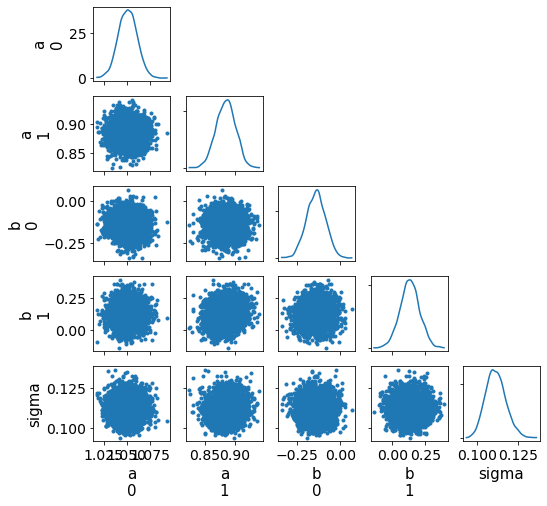

In [25]:
az.plot_pair(m_9_14_trace, figsize=[8, 8], marginals=True)

#### Examining the chain. 

##### Provided the Markov chain is defined correctly, then it is guaranteed to converge in the long run to the answer we want, the posterior distribution. But some posterior distributions are hard to explore—there will be examples—and the time it would take for them to provide an unbiased approximation is very long indeed.

##### We want to see stationarity in the plots. How is this chain a healthy one? Typically we look for three things in these trace plots: (1) stationarity, (2) good mixing, and (3) convergence.

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a\n0'}>,
        <AxesSubplot:title={'center':'a\n0'}>],
       [<AxesSubplot:title={'center':'a\n1'}>,
        <AxesSubplot:title={'center':'a\n1'}>],
       [<AxesSubplot:title={'center':'b\n0'}>,
        <AxesSubplot:title={'center':'b\n0'}>],
       [<AxesSubplot:title={'center':'b\n1'}>,
        <AxesSubplot:title={'center':'b\n1'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

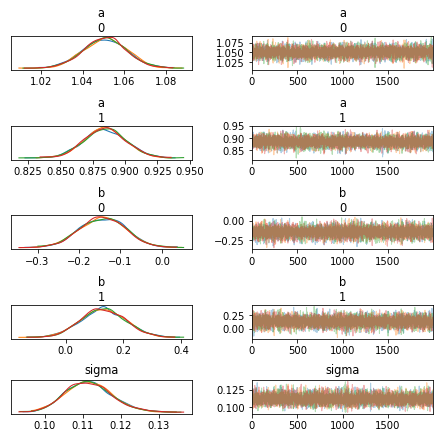

In [36]:
az.plot_trace(m_9_14_trace, figsize=[6,6], var_names=["a","b", "sigma"], compact=False)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

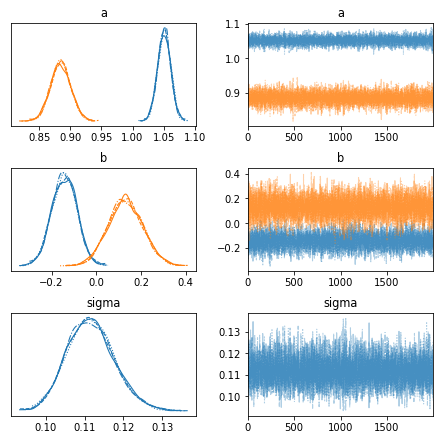

In [37]:
az.plot_trace(m_9_14_trace, figsize=[6,6], var_names=["a","b", "sigma"], compact=True)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a\n0'}>,
        <AxesSubplot:title={'center':'a\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'a\n1'}>,
        <AxesSubplot:title={'center':'a\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'b\n0'}>,
        <AxesSubplot:title={'center':'b\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'b\n1'}>,
        <AxesSubplot:title={'center':'b\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

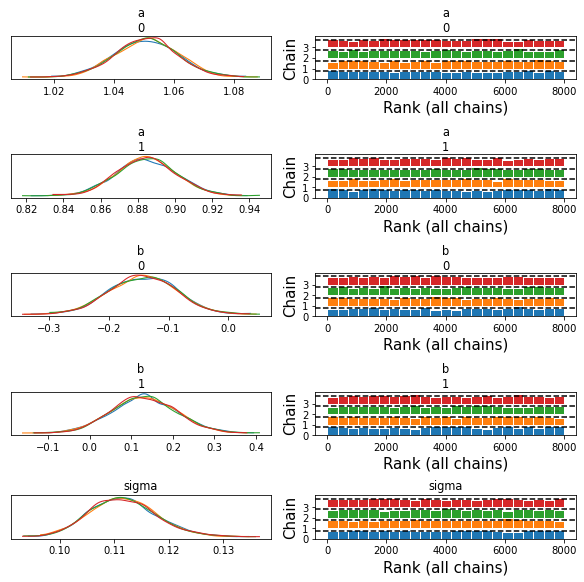

In [43]:
az.plot_trace(m_9_14_trace, figsize=[8,8], var_names=["a","b", "sigma"], compact=False, kind="rank_bars")

#### How many chains do we need?

#### It is very common to run more than one Markov chain, when estimating a single model.

##### The first time you try to sample from a chain, you might not be sure whether the chain is working right. So of course you will check the trace plot or trank plot. Having more than one chain during these checks helps to make sure that the Markov chains are all converging to the same distribution. Sometimes, individual chains look like they’ve settled down to a stable distribution, but if you run the chain again, it might settle down to a different distribution. When you run multiple Markov chains, each with different starting positions, and see that all of them end up in the same region of parameter space, it provides a check that the machine is working correctly. Using 3 or 4 chains is often enough to reassure us that the sampling is working properly.

##### But once you’ve verified that the sampling is working well, and you have a good idea of how many warmup samples you need, it’s perfectly safe to just run one long chain

#### Let's examine a bad chain

In [47]:
y = np.array([-1, 1])

with pm.Model() as m_9_15:
    a = pm.Normal("a", 0, 1_000)
    sigma = pm.Exponential("sigma", 0.0001)
    
    mu = a
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y)
    
    m_9_15_trace = pm.sample(chains=3)

<ipython-input-47-42c99dcb813e>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m_9_15_trace = pm.sample(chains=3)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma, a]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 4 seconds.
There were 222 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6769521101716186, but should be close to 0.8. Try to increase the number of tuning steps.
There were 210 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6433079789663808, but should be close to 0.8. Try to increase the number of tuning steps.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6920101482443856, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some paramet

In [48]:
az.summary(m_9_15_trace)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-7.033,421.041,-875.736,747.834,21.699,16.952,432.0,400.0,1.05
sigma,660.624,1249.599,17.448,2442.873,70.127,49.633,49.0,40.0,1.07


#### This is clearly wrong since the mean of [-1, 1] is zero, so the mean value for alpha ought to be close to zero but we do not get that an we also get an enormous hdi. The inference for sigma is also way off. r_hat is above 1 which is another red flag (as well as the errors raised for the model). These errors indicate 'divergent transitions. Let's look at the trace plot.

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

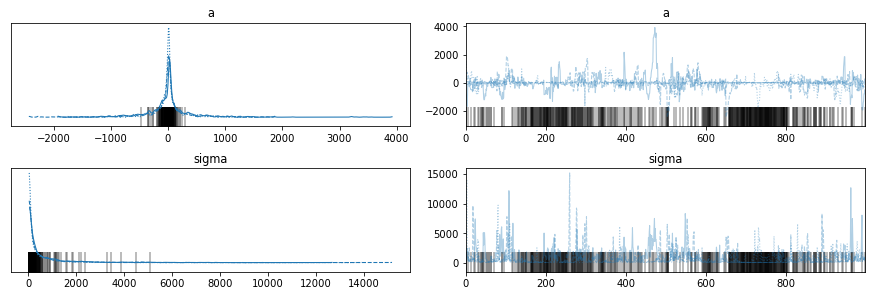

In [49]:
az.plot_trace(m_9_15_trace)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

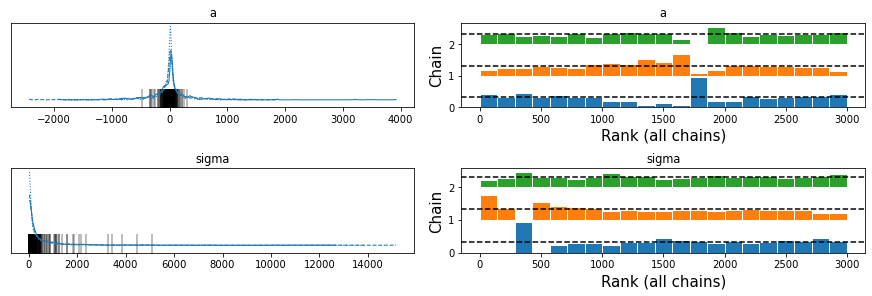

In [50]:
az.plot_trace(m_9_15_trace, kind="rank_bars")

#### The chains occasionally spike around extreme values and do not look healthy.

#### We can tame this chain by using weakly informative priors. The above model drifts so much as there's only two observations and flat priors. These flat priors enable every possible value of the posterior to be equally plausible, a prior. Since the parameter alpha can take a potentially infinite number of values, this means that the Markov chain needs to occasionally sample some pretty extreme and implausible values. Let's try:

$$y_{i} \sim Normal(\mu, \sigma)$$
$$\mu = \alpha$$
$$\alpha \sim Normal(1, 10)$$
$$\sigma \sim Exponential(1)$$

In [52]:
y = np.array([-1, 1])

with pm.Model() as m_9_16:
    a = pm.Normal("a", 1, 10)
    sigma = pm.Exponential("sigma", 1)
    mu = a
    
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y)
    
    m_9_16_trace = pm.sample(chains=3)
    

<ipython-input-52-f87658e744a7>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m_9_16_trace = pm.sample(chains=3)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma, a]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 4 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [53]:
az.summary(m_9_16_trace)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.000,1.221,-2.386,2.292,0.046,0.034,770.0,649.0,1.0
sigma,1.596,0.834,0.425,3.106,0.027,0.019,946.0,1044.0,1.0


/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

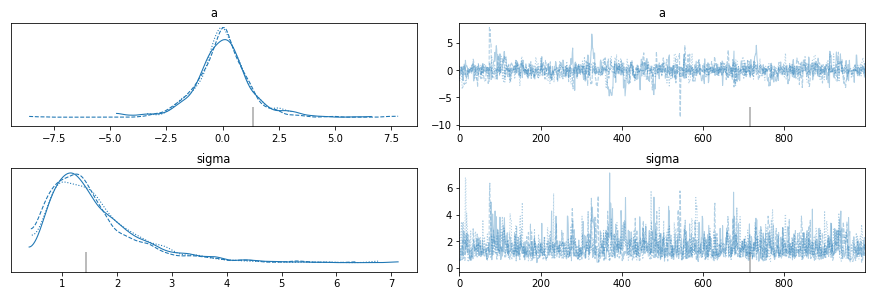

In [54]:
az.plot_trace(m_9_16_trace)

#### Looking good! Let's have a look at the priors and posteriors now.

In [57]:
with m_9_16:
    m_9_16_priors = pm.sample_prior_predictive(1_000, var_names=["a", "sigma"])
    m_9_16_posterior = pm.sample_posterior_predictive(m_9_16_trace, 1_000, var_names=["a", "sigma"])

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [70]:
def prior_post_plot(ax_idx, prior_post_tup, var, xlim, prior_plot_kwargs={}, post_plot_kwargs={}):
    
    prior, posterior = prior_post_tup
    az.plot_kde(prior[var], ax=ax_idx, **prior_plot_kwargs)
    az.plot_kde(posterior[var], ax=ax_idx, **prior_plot_kwargs)
    ax_idx.set_xlim(xlim)
    ax_idx.set_label(var)

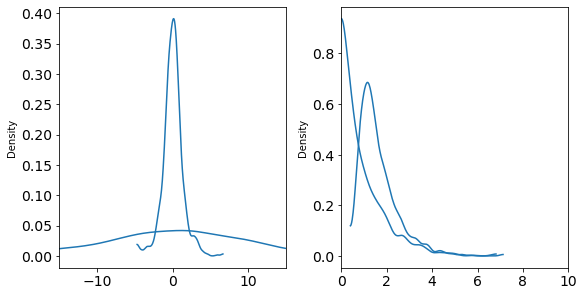

In [74]:
_, axs = plt.subplots(1, 2, figsize=[8, 4], constrained_layout=True)
ax_0, ax_1 = axs

prior_post_plot(ax_0, (m_9_16_priors, m_9_16_posterior), "a", xlim=(-15, 15))
prior_post_plot(ax_1, (m_9_16_priors, m_9_16_posterior), "sigma", xlim=(0, 10))

for ax in axs:
    ax.set_ylabel("Density")

#### Non identifiable parameters
#### Typically a problem with highly correlated predictors. We will see some bad chains which produce characteristic behaviour for when things this issue more broadly. We will also see how we can identify these parameters by using prior information.

#### Start with:
$$y_{i} \sim Normal(\mu, \sigma)$$
$$\mu = \alpha_{1} + \alpha_{2}$$
$$\alpha_{1} \sim Normal(0, 1000)$$
$$\alpha_{2} \sim Normal(0, 1000)$$
$$\sigma \sim Exponential(1)$$

#### The linear model contains two parameters, α1 and α2, which cannot be identified. Only their sum can be identified, and it should be about zero, after estimation.


In [79]:
y = np.random.normal(loc=0, scale=1, size=100)

In [80]:
with pm.Model() as m_9_17:
    a1 = pm.Normal("a1", 0, 1_000)
    a2 = pm.Normal("a2", 0, 1_000)
    
    sigma = pm.Exponential("sigma", 1)
    
    mu = a1 + a2
    
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y)
    
    m_9_17_trace = pm.sample(chains=3)

<ipython-input-80-4fc67f2f8ed7>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m_9_17_trace = pm.sample(chains=3)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma, a2, a1]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 283 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9063362741784047, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [81]:
az.summary(m_9_17_trace)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,247.156,789.471,-988.682,1383.187,396.787,304.310,5.0,32.0,1.64
a2,-247.164,789.470,-1383.322,988.664,396.787,304.310,5.0,32.0,1.64
sigma,0.944,0.067,0.827,1.071,0.011,0.008,38.0,133.0,1.08


/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a1'}>,
        <AxesSubplot:title={'center':'a1'}>],
       [<AxesSubplot:title={'center':'a2'}>,
        <AxesSubplot:title={'center':'a2'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

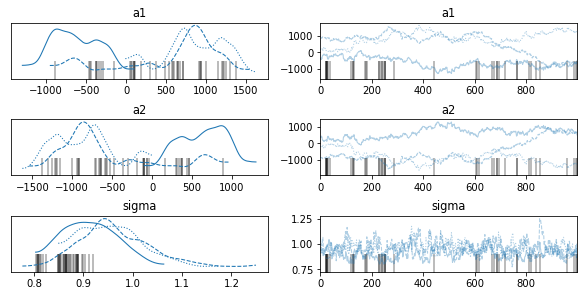

In [82]:
az.plot_trace(m_9_17_trace, figsize=[8,4])

#### The estimates are mess, bad r_hat values above 1, the means for a1 and a2 are virtually the same distance from zero but with opposite signs and the standard deviations are enormous. We also hit a load of errors.

#### A strategy to deal with this identification issue is to use some weakly regularising priors instead.

In [83]:
y = np.random.normal(loc=0, scale=1, size=100)
with pm.Model() as m_9_18:
    a1 = pm.Normal("a1", 0, 10)
    a2 = pm.Normal("a2", 0, 10)
    
    sigma = pm.Exponential("sigma", 1)
    
    mu = a1 + a2
    
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y)
    
    m_9_18_trace = pm.sample(chains=3)

<ipython-input-83-3835ec412f54>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m_9_18_trace = pm.sample(chains=3)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sigma, a2, a1]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 54 seconds.


In [84]:
az.summary(m_9_18_trace)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,-0.263,7.201,-14.109,13.653,0.229,0.174,1001.0,760.0,1.0
a2,0.250,7.203,-13.738,14.025,0.229,0.174,1000.0,785.0,1.0
sigma,0.969,0.069,0.851,1.107,0.002,0.001,1329.0,1282.0,1.0


/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a1'}>,
        <AxesSubplot:title={'center':'a1'}>],
       [<AxesSubplot:title={'center':'a2'}>,
        <AxesSubplot:title={'center':'a2'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

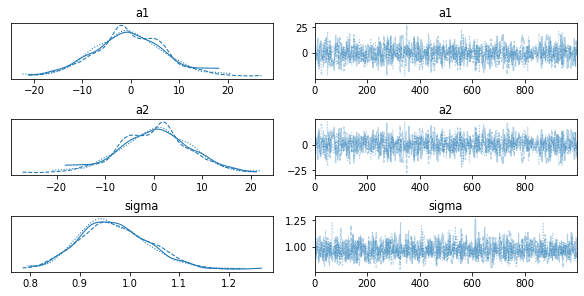

In [85]:
az.plot_trace(m_9_18_trace, figsize=[8,4])